<a href="https://colab.research.google.com/github/vaidehi2002vd/nimbus-astro/blob/master/Forced_Photometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import astropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from photutils.segmentation import detect_sources
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.segmentation import SourceFinder, SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.wcs import WCS, wcs
from reproject import reproject_interp
from scipy import ndimage, datasets
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve
from photutils.background import SExtractorBackground, MeanBackground
from astropy import units as u
from astropy import table
from astropy.table import QTable as Table
from photutils.aperture import BoundingBox, Aperture, PixelAperture, ApertureMask, EllipticalAperture

### **Photometry on Z Band**

**Storing the locations of required files**

In [ ]:
HSC_G_name    = '2-cutout-HSC-G-9075-pdr3_wide.fits'
HSC_R_name    = '3-cutout-HSC-R-9075-pdr3_wide.fits'
HSC_I_name    = '4-cutout-HSC-I-9075-pdr3_wide.fits'
HSC_Z_name    = '5-cutout-HSC-Z-9075-pdr3_wide.fits'
HSC_Y_name    = '6-cutout-HSC-Y-9075-pdr3_wide.fits'

HST_F110_name = 'ibjj05010_drz.fits'
HST_F160_name = 'ibjj05030_drz.fits'

Checking the extensions in each file

In [ ]:
fits.info(HSC_Z_name)

Filename: 5-cutout-HSC-Z-9075-pdr3_wide.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1                1 ImageHDU        31   (5955, 5953)   float32   
  2                1 ImageHDU        48   (5955, 5953)   int32   
  3                1 ImageHDU        31   (5955, 5953)   float32   


Opening Z file

In [ ]:
open_HSC_Z = fits.open(HSC_Z_name)
img_HSC_Z  = open_HSC_Z[1]
data_HSC_Z = img_HSC_Z.data.astype('float32')

Plotting the image

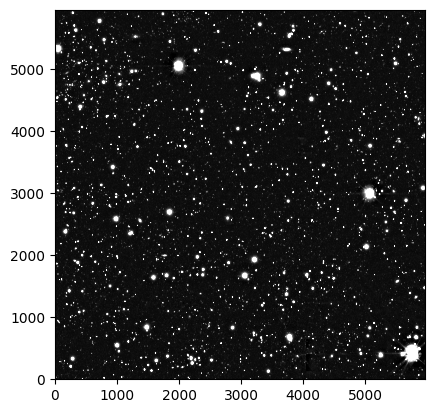

In [ ]:
plt.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Viewing the header

In [ ]:
header_Z_band = WCS(img_HSC_Z.header)
header_Z_band

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 135.371900826446  -2.23140495867768  
CRPIX : 11336.0  -8606.0  
CD1_1 CD1_2  : -4.666666666664e-05  0.0  
CD2_1 CD2_2  : 0.0  4.66666666666372e-05  
NAXIS : 5955  5953

Subtracting an estimate of the background using SEXtractor

In [ ]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_Z)
filt_data_HSC_Z = data_HSC_Z - bkg_value

Plotting both filtered and actual image

<ipython-input-96-5df883a0688d>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-96-5df883a0688d>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


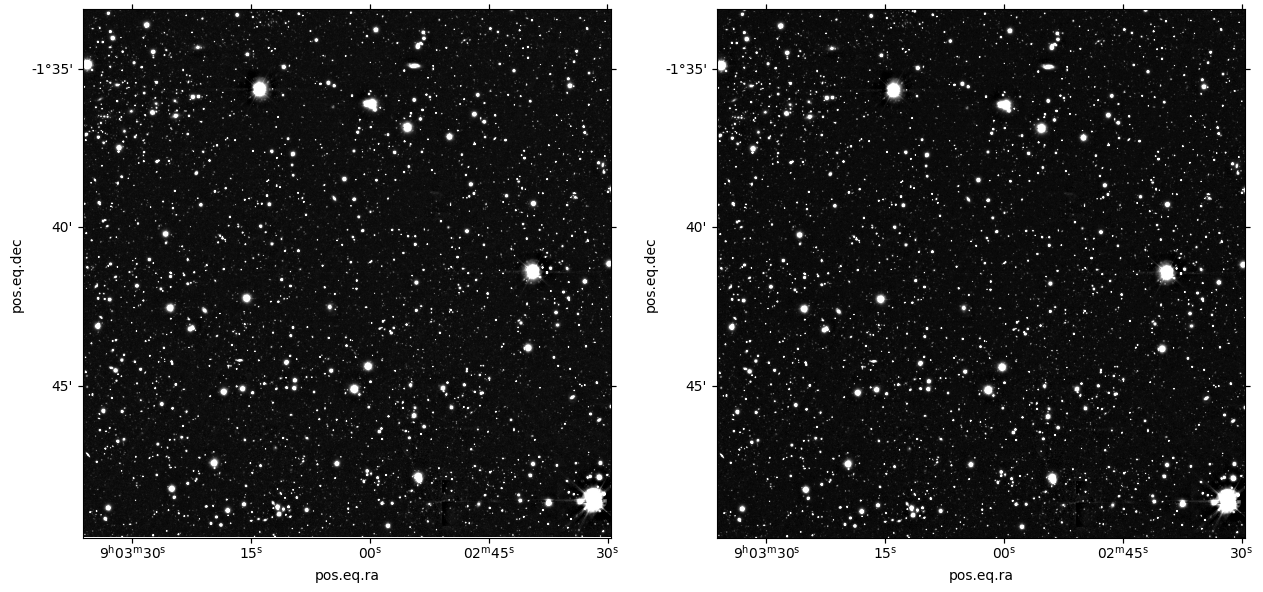

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Using ds9, find too bright sources and mask them

In [ ]:
mask = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool)
mask[157:627, 5517:5907].fill(True)
mask[2829:3128, 4929:5182].fill(True)
mask[4772:4972, 3126:3361].fill(True)
mask[4892:5179, 1863:2125].fill(True)
mask[4678:5060, 3059:3409].fill(True)
mask[4527:4693, 3557:3732].fill(True)
mask[565:756, 3696:3849].fill(True)
mask[1319:1477, 3686:3769].fill(True)
mask[1578:1732, 2938:3140].fill(True)
mask[1619:1718, 1716:1842].fill(True)
mask[1319:1477, 3686:3769].fill(True)
mask[5234:5407, 0:127].fill(True)

In [ ]:
kernel = make_2dgaussian_kernel(3.0, size=3)
convolved_data = convolve(data_HSC_Z, kernel)
segment_map = detect_sources(convolved_data, threshold=.25, npixels=10, mask=mask)

In [ ]:
fits.writeto('segment_map.fits', segment_map, overwrite=True)

KeyError: ignored

<ipython-input-99-5dd26bcc69bb>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-99-5dd26bcc69bb>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


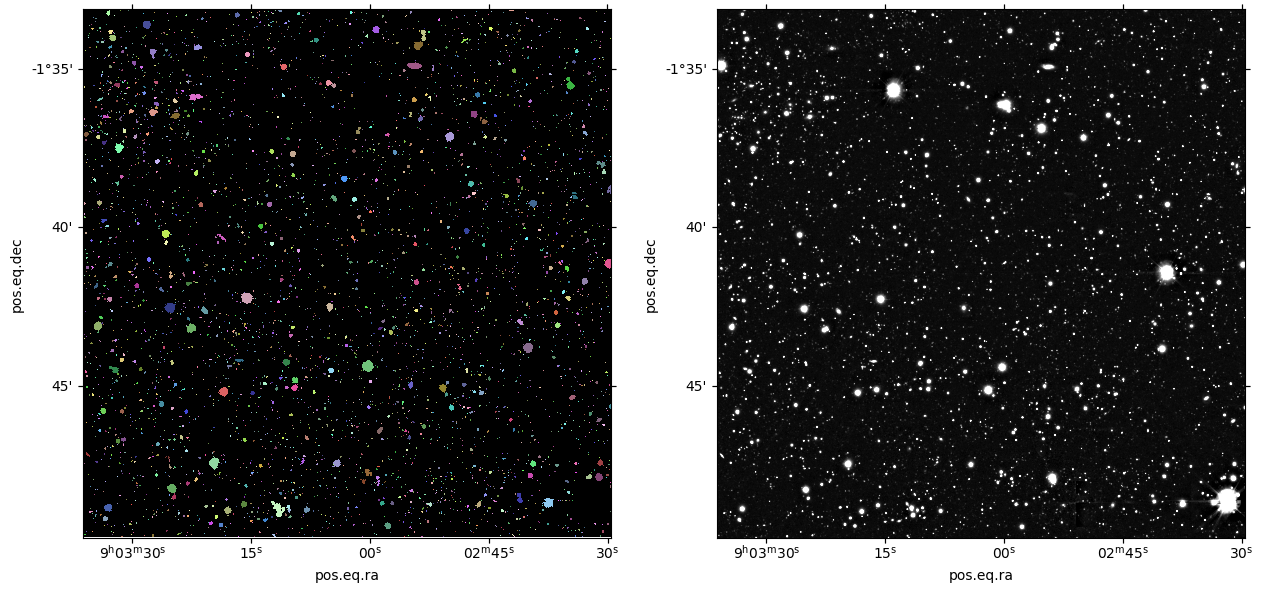

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False)

<ipython-input-106-34dca7092b54>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1, projection = header_Z_band)
<ipython-input-106-34dca7092b54>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 3, 2, projection = header_Z_band)
<ipython-input-106-34dca7092b54>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(1, 3, 3, projection = header_Z_band)


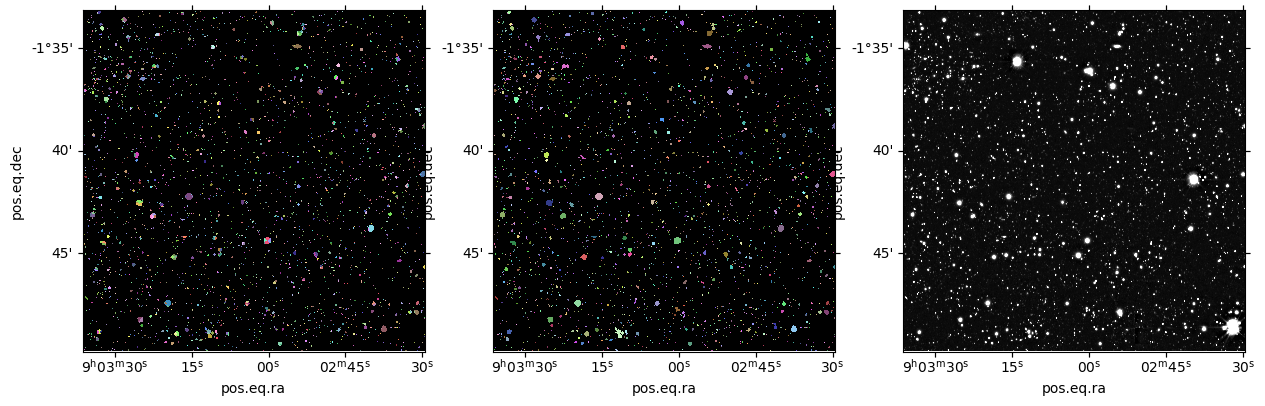

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))

ax1 = plt.subplot(1, 3, 1, projection = header_Z_band)
ax1.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 3, 2, projection = header_Z_band)
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax3 = plt.subplot(1, 3, 3, projection = header_Z_band)
ax3.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
cat_blend = SourceCatalog(filt_data_HSC_Z, segment_map, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z_band, mask=mask)
Z_sources_blend = cat_blend.to_table()

In [ ]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False)

KeyboardInterrupt: ignored

In [110]:
for i in range(len(Z_sources_blend)):
  if Z_sources_blend['xcentroid'][i] > 3200 and Z_sources_blend['xcentroid'][i] < 3225:
    if Z_sources_blend['ycentroid'][i] > 1910 and Z_sources_blend['ycentroid'][i] < 1940:
      print(i)

3122


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3123,3209.281672637726,1919.7088944882814,"135.75125649026316,-1.740132461484287",3142,3276,1856,1993,12818.0,16.198356373925986,15.771519760846672,23.620719659967612,0.22805014877673205,-0.9531318023616902,112.39956914635351,-0.013529412466801033,67166.36273817827,nan,65998.98930214088,nan


In [ ]:
from photutils.aperture.ellipse import EllipticalAperture
#check with ds9 and notes coordinates
index = [370, 6037, 9336, 9533]
x_too_big = []
y_too_big = []
bbox_xmin = []
bbox_ymin = []
bbox_xmax = []
bbox_ymax = []
# theta     = []
# semimajor = []
# semiminor = []
for i in index:
  x_too_big.append(Z_sources_blend['xcentroid'][i])
  y_too_big.append(Z_sources_blend['ycentroid'][i])
  # semimajor.append(Z_sources_blend['semimajor_sigma'][i].to_value())
  # semiminor.append(Z_sources_blend['semiminor_sigma'][i].to_value())
  # theta.append(Z_sources_blend['orientation'][i])
  bbox_xmin.append(int(Z_sources_blend['bbox_xmin'][i]))
  bbox_xmax.append(int(Z_sources_blend['bbox_xmax'][i]))
  bbox_ymin.append(int(Z_sources_blend['bbox_ymin'][i]))
  bbox_ymax.append(int(Z_sources_blend['bbox_ymax'][i]))


positions = np.transpose((x_too_big, y_too_big))

bbox0 = BoundingBox(bbox_xmin[0], bbox_xmax[0], bbox_ymin[0], bbox_ymax[0])
bbox1 = BoundingBox(bbox_xmin[1], bbox_xmax[1], bbox_ymin[1], bbox_ymax[1])
bbox2 = BoundingBox(bbox_xmin[2], bbox_xmax[2], bbox_ymin[2], bbox_ymax[2])
bbox3 = BoundingBox(bbox_xmin[3], bbox_xmax[3], bbox_ymin[3], bbox_ymax[3])
# aperture0 = EllipticalAperture(positions[0], a=semimajor[0], b=semiminor[0], theta=theta[0])
# aperture1 = EllipticalAperture(positions[1], a=semimajor[1], b=semiminor[1], theta=theta[1])
# aperture2 = EllipticalAperture(positions[2], a=semimajor[2], b=semiminor[2], theta=theta[2])
# aperture3 = EllipticalAperture(positions[3], a=semimajor[3], b=semiminor[3], theta=theta[3])
# mask0 = aperture0.to_mask()
# mask1 = aperture1.to_mask()
# mask2 = aperture2.to_mask()
# mask3 = aperture3.to_mask()

mask = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool)
mask[157:627, 5517:5907].fill(True)
mask[2829:3128, 4929:5182].fill(True)
mask[4772:4972, 3126:3361].fill(True)
mask[4892:5179, 1863:2125].fill(True)


In [ ]:
kernel = make_2dgaussian_kernel(3.0, size=3)
convolved_data = convolve(filt_data_HSC_Z, kernel)
segment_map = detect_sources(convolved_data, threshold=.2, npixels=10, mask=mask)

<ipython-input-211-5dd26bcc69bb>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-211-5dd26bcc69bb>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


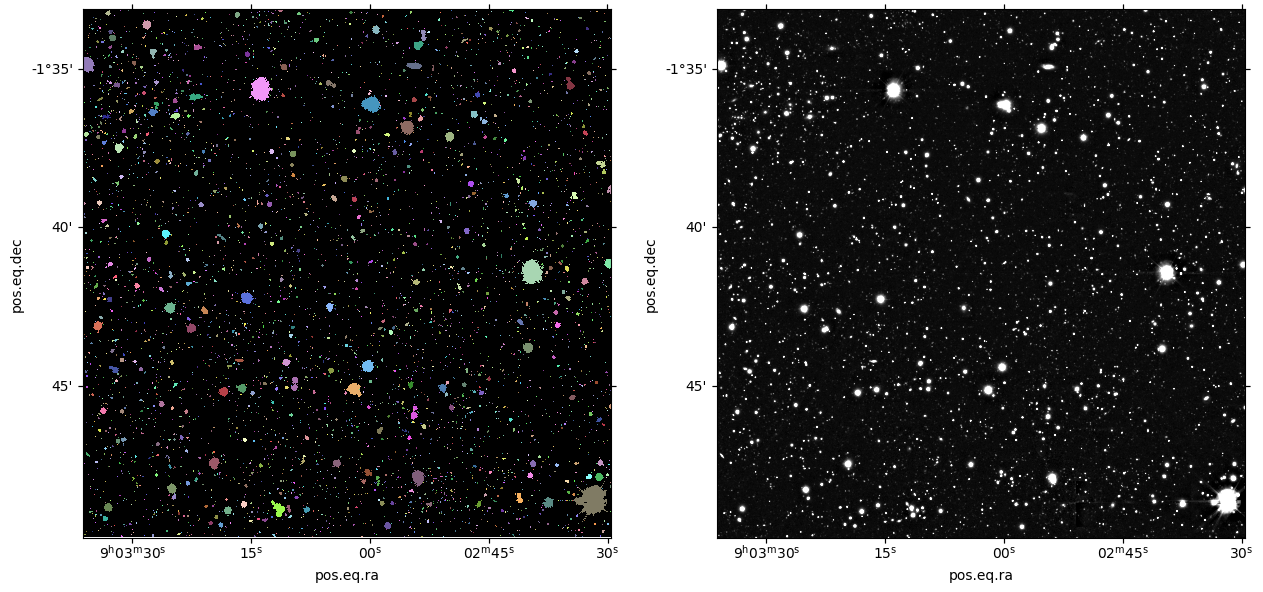

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False)

<ipython-input-27-9014d985f7ec>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
<ipython-input-27-9014d985f7ec>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


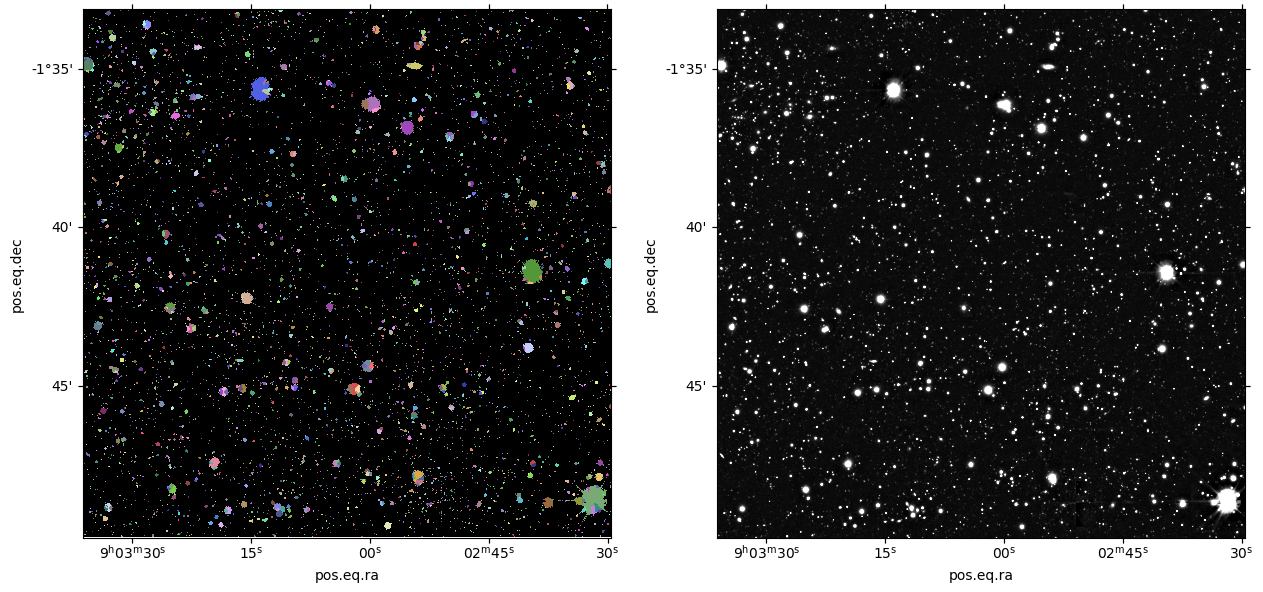

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
ax1.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

In [ ]:
cat = SourceCatalog(filt_data_HSC_Z, segm_deblend, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z_band)
Z_sources_FP = cat.to_table()

In [ ]:
Z_sources_FP

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,SkyCoord,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,313.9872523283124,1.1647494375463094,"135.88645063312376,-1.829623453151341",310,318,0,4,32.0,1.7109016116618345,1.0599957519407583,7.136955839927177,0.7849541229859056,0.0015338166803121611,3.3230508594959973,0.0362530917674303,24.891172665953636,nan,28.39141202138449,nan
2,375.28912402362306,2.913326921520435,"135.8835886913066,-1.829542678049421",371,381,0,6,49.0,2.2197506818461803,1.587144441799756,6.819708867100792,0.6991139917237456,0.04107242551011343,1.0858753743426253,0.05697049472170572,16.586780318136636,nan,17.83679365663831,nan
3,402.8495534531744,2.462832961251788,"135.88230202320892,-1.8295640654520509",400,406,0,6,30.0,1.656678637564794,1.3927827081023099,-48.110607266486355,0.5414890015352184,-0.25028690240847373,0.7648739115191767,0.03304589829909113,8.452429967502562,nan,13.665719482789417,nan
4,1365.2244685430048,2.053898578546066,"135.83737265734683,-1.8295953574058075",1363,1368,0,5,31.0,1.5374828220254122,1.3896133184997221,-55.1398574076828,0.4279051650705793,-0.06068165195465554,0.9516961140063358,0.07549767070740927,11.504489687041495,nan,8.512151733533155,nan
5,1749.4035622346614,2.066570848189829,"135.81943673409984,-1.8295993263701933",1742,1755,0,6,60.0,3.062293403360709,1.4996365199411936,-1.705095919914336,0.8718852301048805,-0.06888702820604628,0.940099809955899,-0.042672966312710586,24.555388752879598,nan,51.448225016701215,nan
6,1930.2345410310436,6.18959729100624,"135.81099430610647,-1.8294090180816382",1921,1942,0,16,216.0,2.3978569655951243,2.315532709988412,4.184488598852961,0.2597809531012345,-0.1335161931007325,29.769168733885962,-0.0421446555168212,506.01852821733837,nan,497.5501762382524,nan
7,2280.5783033827,1.494044910221322,"135.79463798342198,-1.8296320522828553",2277,2284,0,3,23.0,1.8692098928107372,0.8946616478156704,-12.792218152917219,0.8780161979606398,-0.14347536640852923,0.8473685405901051,0.016161081964673946,7.885654023465759,nan,10.561229213750664,nan
8,2315.1852528329537,5.975247131406795,"135.79302223609568,-1.8294233251380685",2310,2320,0,12,102.0,2.1785798009436896,1.90732288754827,-83.31302985240056,0.48323785141413905,0.01916327585182074,5.945759215407957,-0.018817820602049264,111.71050899892936,nan,117.9395771738074,nan
